### Q: How do neutral codon probabilities compare to empirical ones?

* How does the answer depend on branch lengths?
* How do multinucleotide codon probabilities compare?

**Terminology**: the _hit class_ of a codon mutation describes the number of differences from the parent codon. E.g. `AAA -> ACT` has hit class 2. I use this terminology to avoid overloaded terms like "number of differences" which gets confusing when we are talking about number of overall differences from parent.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES

from epam import molevol, sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

from shmex.shm_data import load_shmoof_dataframes, pcp_df_of_non_shmoof_nickname, dataset_dict
from shmex.shm_eval import oe_plot_of, optimized_branch_lengths_of_crepe

Using Metal Performance Shaders


In [2]:
crepe_path = "../train/trained_models/cnn_joi_lrg-shmoof_small-fixed-0"
crepe = framework.load_crepe(crepe_path)
model = crepe.model
site_count = 500

We're just going to use shmoof training data, the same data used to train the context NT model.

In [3]:
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df["branch_length"] = pd.read_csv(crepe_path+".train_branch_lengths.csv")["branch_length"]
pcp_df = train_df


In [4]:
tang_df = pcp_df_of_non_shmoof_nickname("tangshm")
subsampled_tang_df = tang_df.iloc[::int(len(tang_df)/4000)].copy().reset_index(drop=True)
subsampled_tang_df["branch_length"] = optimized_branch_lengths_of_crepe(crepe, subsampled_tang_df)

# take the first 1000 row
# pcp_df = pcp_df[:1000].copy()

Loading /Users/matsen/data/v1/tang-deepshm-oof_pcp_2024-04-09_MASKED_NI.csv.gz


Finding optimal branch lengths: 100%|██████████| 4992/4992 [00:21<00:00, 231.27it/s]


In [5]:
pcp_df = subsampled_tang_df

In [6]:
def trim_seqs_to_codon_boundary_and_max_len(seqs):
    max_len = site_count - site_count % 3
    return [seq[:min(len(seq) - len(seq) % 3, max_len)] for seq in seqs]

def prepare_pcp_df(pcp_df):
    """
    Trim the sequences to codon boundaries and add the rates and substitution probabilities.
    """
    pcp_df["parent"] = trim_seqs_to_codon_boundary_and_max_len(pcp_df["parent"])
    pcp_df["child"] = trim_seqs_to_codon_boundary_and_max_len(pcp_df["child"])
    pcp_df = pcp_df[pcp_df["parent"] != pcp_df["child"]].reset_index(drop=True)
    ratess, cspss = framework.trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    pcp_df["rates"] = ratess
    pcp_df["subs_probs"] = cspss
    return pcp_df

pcp_df = prepare_pcp_df(pcp_df)
assert pcp_df["parent"].apply(len).max() <= site_count - site_count % 3

#### Now let's move on to the codon-level process

In [7]:
def codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, sub_probs):
    """
    Compute the probabilities of mutating to various codons for a parent sequence. 
    
    This uses the same machinery as we use for fitting the DNSM, but we stay on
    the codon level rather than moving to syn/nonsyn changes.
    """
    # This is from `aaprobs_of_parent_scaled_rates_and_sub_probs`:
    mut_probs = 1.0 - torch.exp(-scaled_rates)
    parent_codon_idxs = reshape_for_codons(parent_idxs)
    codon_mut_probs = reshape_for_codons(mut_probs)
    codon_sub_probs = reshape_for_codons(sub_probs)
    
    # This is from `aaprob_of_mut_and_sub`:
    mut_matrices = build_mutation_matrices(parent_codon_idxs, codon_mut_probs, codon_sub_probs)
    codon_probs = codon_probs_of_mutation_matrices(mut_matrices)

    return codon_probs

The following sets us up to work with "hit classes", which are the number of differences within a codon as described above. That is, we're calculating the probability of $x$ mutations within a codon given the model.

In [8]:
# This block just sets up `hit_class_tensors`, a dictionary of tensors that we can use to compute the number of differences between codons, as well as `codon_to_idxs` which maps codons to their indices in the tensors.

# Function to calculate the number of differences between two codons
def hit_class(codon1, codon2):
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

# Initialize a dictionary to store hit_class_tensors indexed by codons
hit_class_tensors = {}

# Iterate over all possible codons and calculate the hit_class_tensors
for i, base1 in enumerate(BASES):
    for j, base2 in enumerate(BASES):
        for k, base3 in enumerate(BASES):
            codon = base1 + base2 + base3
            hit_class_tensor = torch.zeros(4, 4, 4, dtype=torch.int)
            for i2, base1_2 in enumerate(BASES):
                for j2, base2_2 in enumerate(BASES):
                    for k2, base3_2 in enumerate(BASES):
                        codon_2 = base1_2 + base2_2 + base3_2
                        hit_class_tensor[i2, j2, k2] = hit_class(codon, codon_2)
            hit_class_tensors[codon] = hit_class_tensor

# make a dict mapping from codon to triple integer index
codon_to_idxs = {base_1+base_2+base_3: (i, j, k) for i, base_1 in enumerate(BASES) for j, base_2 in enumerate(BASES) for k, base_3 in enumerate(BASES)}
codon_to_idxs

ctc_hit_class_tensor = hit_class_tensors["CTC"]
assert ctc_hit_class_tensor[codon_to_idxs["CTC"]] == 0
assert ctc_hit_class_tensor[codon_to_idxs["ATC"]] == 1
assert ctc_hit_class_tensor[codon_to_idxs["ACC"]] == 2
assert ctc_hit_class_tensor[codon_to_idxs["ACT"]] == 3

In [9]:
def hit_class_probs(hit_class_tensor, codon_probs):
    """
    Calculate total probabilities for each number of differences between codons.

    Args:
    - hit_class_tensor (torch.Tensor): A 4x4x4 integer tensor containing the number of differences
                                       between each codon and a reference codon.
    - codon_probs (torch.Tensor): A 4x4x4 tensor containing the probabilities of various codons.

    Returns:
    - total_probs (torch.Tensor): A 1D tensor containing the total probabilities for each number
                                   of differences (0 to 3).
    """
    total_probs = []

    for hit_class in range(4):
        # Create a mask of codons with the desired number of differences
        mask = hit_class_tensor == hit_class

        # Multiply componentwise with the codon_probs tensor and sum
        total_prob = (codon_probs * mask.float()).sum()

        # Append the total probability to the list
        total_probs.append(total_prob.item())

    return torch.tensor(total_probs)

def hit_class_probs_seq(parent_seq, codon_probs, hit_class_tensors):
    """
    Calculate probabilities of hit classes between parent codons and all other codons for all the sites of a sequence.

    Args:
    - parent_seq (str): The parent nucleotide sequence.
    - codon_probs (torch.Tensor): A tensor containing the probabilities of various codons.
    - hit_class_tensors (dict): A dictionary containing hit_class_tensors indexed by codons.

    Returns:
    - probs (torch.Tensor): A tensor containing the probabilities of different
                            counts of hit classes between parent codons and
                            all other codons.
    """
    # Check if the size of the first dimension of codon_probs matches the length of parent_seq divided by 3
    if len(parent_seq) // 3 != codon_probs.size(0):
        raise ValueError("The size of the first dimension of codon_probs should match the length of parent_seq divided by 3.")

    # Initialize a list to store the probabilities of different counts of differences
    probs = []

    # Iterate through codons in parent_seq
    for i in range(0, len(parent_seq), 3):
        # Extract the codon from parent_seq
        codon = parent_seq[i:i+3]

        # if codon contains an N, append a tensor of 4 -1s to probs then continue
        if "N" in codon:
            probs.append(torch.tensor([-100.0] * 4))
            continue

        # Get the corresponding hit_class_tensor from hit_class_tensors
        hit_class_tensor = hit_class_tensors[codon]

        # Get the ith entry of codon_probs
        codon_probs_i = codon_probs[i // 3]

        # Calculate the probabilities of different counts of differences using the hit_class_tensor and codon_probs_i
        total_probs = hit_class_probs(hit_class_tensor, codon_probs_i)

        # Append the probabilities to the list
        probs.append(total_probs)

    # Concatenate all the probabilities into a tensor
    probs = torch.stack(probs)

    return probs


Now we need to prepare dataframes for the codon-level OE plot.

In [10]:
# This block just shows how things are going to go for a single parent sequence.

parent, rates, subs_probs, branch_length = pcp_df.loc[0, ["parent", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[8.3000e-01, 1.6018e-01, 9.6350e-03, 1.8409e-04],
        [8.9087e-01, 1.0552e-01, 3.5720e-03, 3.6784e-05],
        [8.5815e-01, 1.3482e-01, 6.9145e-03, 1.1634e-04],
        [9.1225e-01, 8.5100e-02, 2.6184e-03, 2.6556e-05],
        [8.6691e-01, 1.2858e-01, 4.4667e-03, 4.3773e-05],
        [9.3705e-01, 6.1591e-02, 1.3481e-03, 9.8261e-06]])

In [11]:
def hit_classes_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-100)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-100] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
example_hit_classes = hit_classes_of_pcp_df(example_df, 4)
example_hit_classes


tensor([[   0,    0,    1, -100],
        [   0,    0,    1,    2]])

In [12]:
def branch_length_quantile_dict_of_pcp_df(pcp_df):
    """
    Maps from the index of a row in pcp_df to the quantile of its branch length.
    """
    branch_length_quantile = pd.qcut(pcp_df["branch_length"], q=4, labels=False)
    branch_length_quantile_dict = branch_length_quantile.to_dict()
    return branch_length_quantile_dict

branch_length_quantile_dict = branch_length_quantile_dict_of_pcp_df(pcp_df)

In [13]:
def hit_class_probs_of_pcp_df(pcp_df, hit_class_tensors):
    all_hc_probs_l = []

    for _, row in tqdm(pcp_df.iterrows(), total=len(pcp_df), desc="Computing hit class probs"):
        parent = row['parent']
        rates = row['rates']
        subs_probs = row['subs_probs']
        branch_length = row['branch_length']

        parent = parent[:len(parent) - len(parent) % 3]
        rates = rates[:len(rates) - len(rates) % 3]
        subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

        parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
        scaled_rates = branch_length * rates

        codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)

        hc_probs = hit_class_probs_seq(parent, codon_probs, hit_class_tensors)
        all_hc_probs_l.append(hc_probs)

    return all_hc_probs_l

def hc_site_df_of_pcp_df(pcp_df, hit_class_tensors):
    """
    Make a df of hit class probabilities and observations at each site in each sequence.
    """
    all_hc_probs_l = hit_class_probs_of_pcp_df(pcp_df, hit_class_tensors)
    observed_hcs = hit_classes_of_pcp_df(pcp_df, site_count//3)
    assert len(observed_hcs) == len(pcp_df)

    df_rows = []
    for seq_idx, (observed_hc_row, hc_probs_row) in enumerate(zip(tqdm(observed_hcs, desc="Consolidating rows"), all_hc_probs_l)):
        for site_idx, (observed_hc, diff_prob_vect) in enumerate(zip(observed_hc_row, hc_probs_row[:len(observed_hc_row)])):
            if observed_hc >= 0: # filtering out N-containing codons
                v = tuple(diff_prob_vect.detach().numpy())
                df_rows.append((seq_idx, site_idx, observed_hc.item()) + v)
        
    hc_site_df = pd.DataFrame(df_rows, columns=["sequence", "site", "hit_class", "0_hc_prob", "1_hc_prob", "2_hc_prob", "3_hc_prob"])
    hc_site_df["branch_length_quantile"] = hc_site_df["sequence"].map(branch_length_quantile_dict)

    return hc_site_df

hc_site_df = hc_site_df_of_pcp_df(pcp_df, hit_class_tensors)
hc_site_df

Consolidating rows: 100%|██████████| 4992/4992 [00:02<00:00, 1732.27it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,0,0,0.810934,0.176563,0.012240,0.000263,3
1,0,1,0,0.842248,0.149177,0.008426,0.000149,3
2,0,2,2,0.661703,0.299156,0.037716,0.001425,3
3,0,3,1,0.682490,0.280245,0.035818,0.001447,3
4,0,4,0,0.831070,0.158862,0.009870,0.000197,3
...,...,...,...,...,...,...,...,...
610483,4991,114,0,0.789823,0.194097,0.015665,0.000415,3
610484,4991,115,0,0.732186,0.242495,0.024611,0.000707,3
610485,4991,116,0,0.774585,0.206907,0.017995,0.000512,3
610486,4991,117,0,0.857347,0.135866,0.006691,0.000096,3


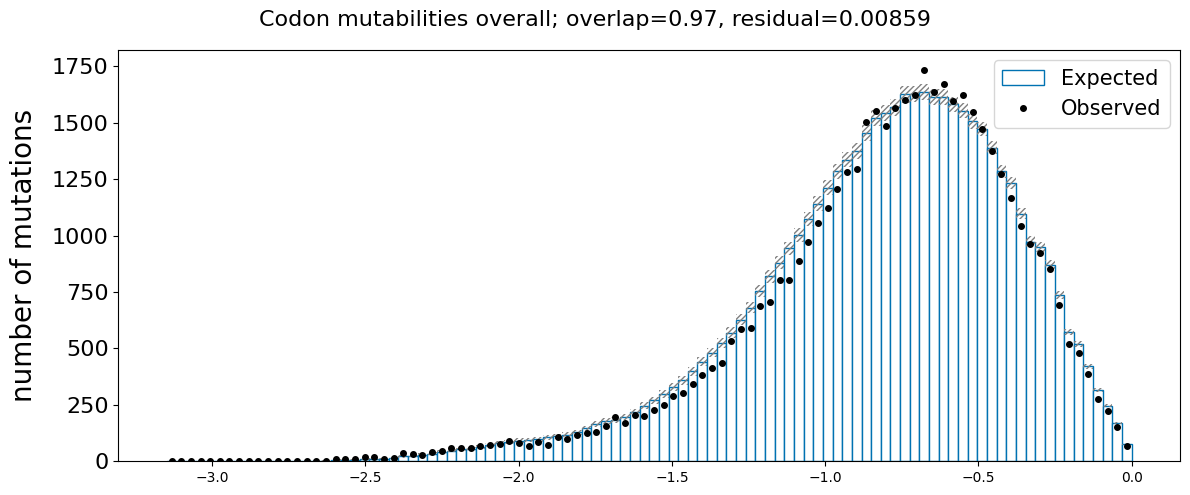

In [14]:
def simple_codon_oe_plot(hc_site_df, description):
    """
    No partitioning by mutation class.
    """
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] > 0,
        "prob": 1 - hc_site_df["0_hc_prob"],
    })
    fig, axs = plt.subplots(1, 1, figsize=(12, 5))
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs, None)
    fig.suptitle(f"{description}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}", fontsize=16)    
    fig.tight_layout()
    return fig, result_dict

fig, result_dict = simple_codon_oe_plot(hc_site_df, "Codon mutabilities overall")

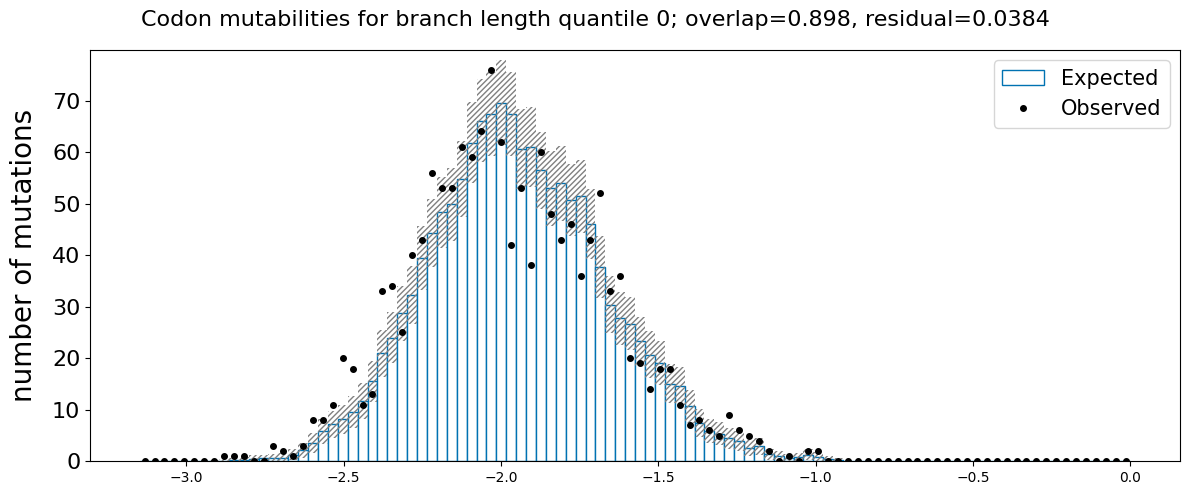

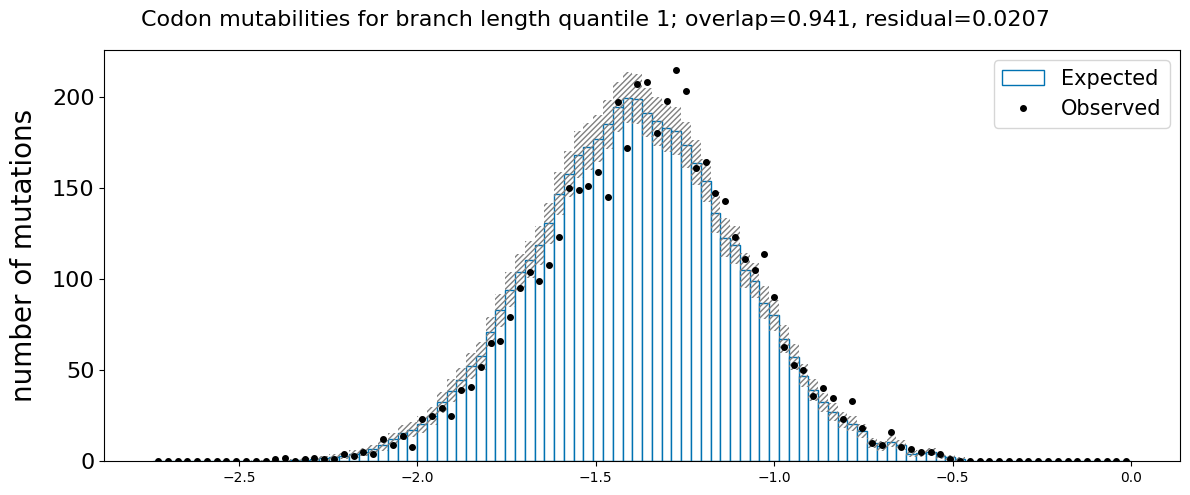

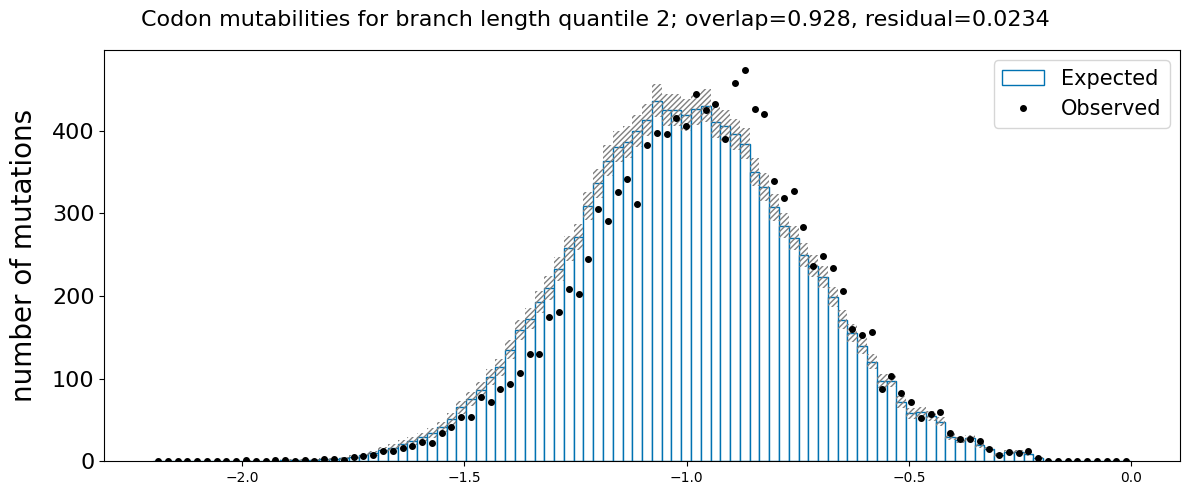

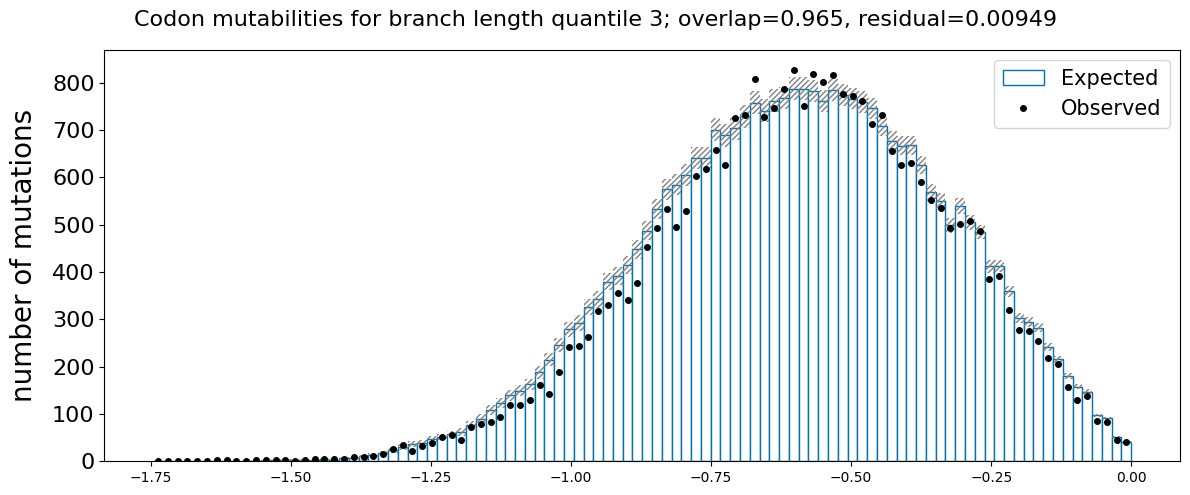

In [15]:
# loop over a groupby of pcp_df["branch_length_quantile"]
figs = []
results = []
for quantile, group in hc_site_df.groupby("branch_length_quantile"):
    fig, result = simple_codon_oe_plot(group, f"Codon mutabilities for branch length quantile {quantile}")
    figs.append(fig)
    results.append(result)

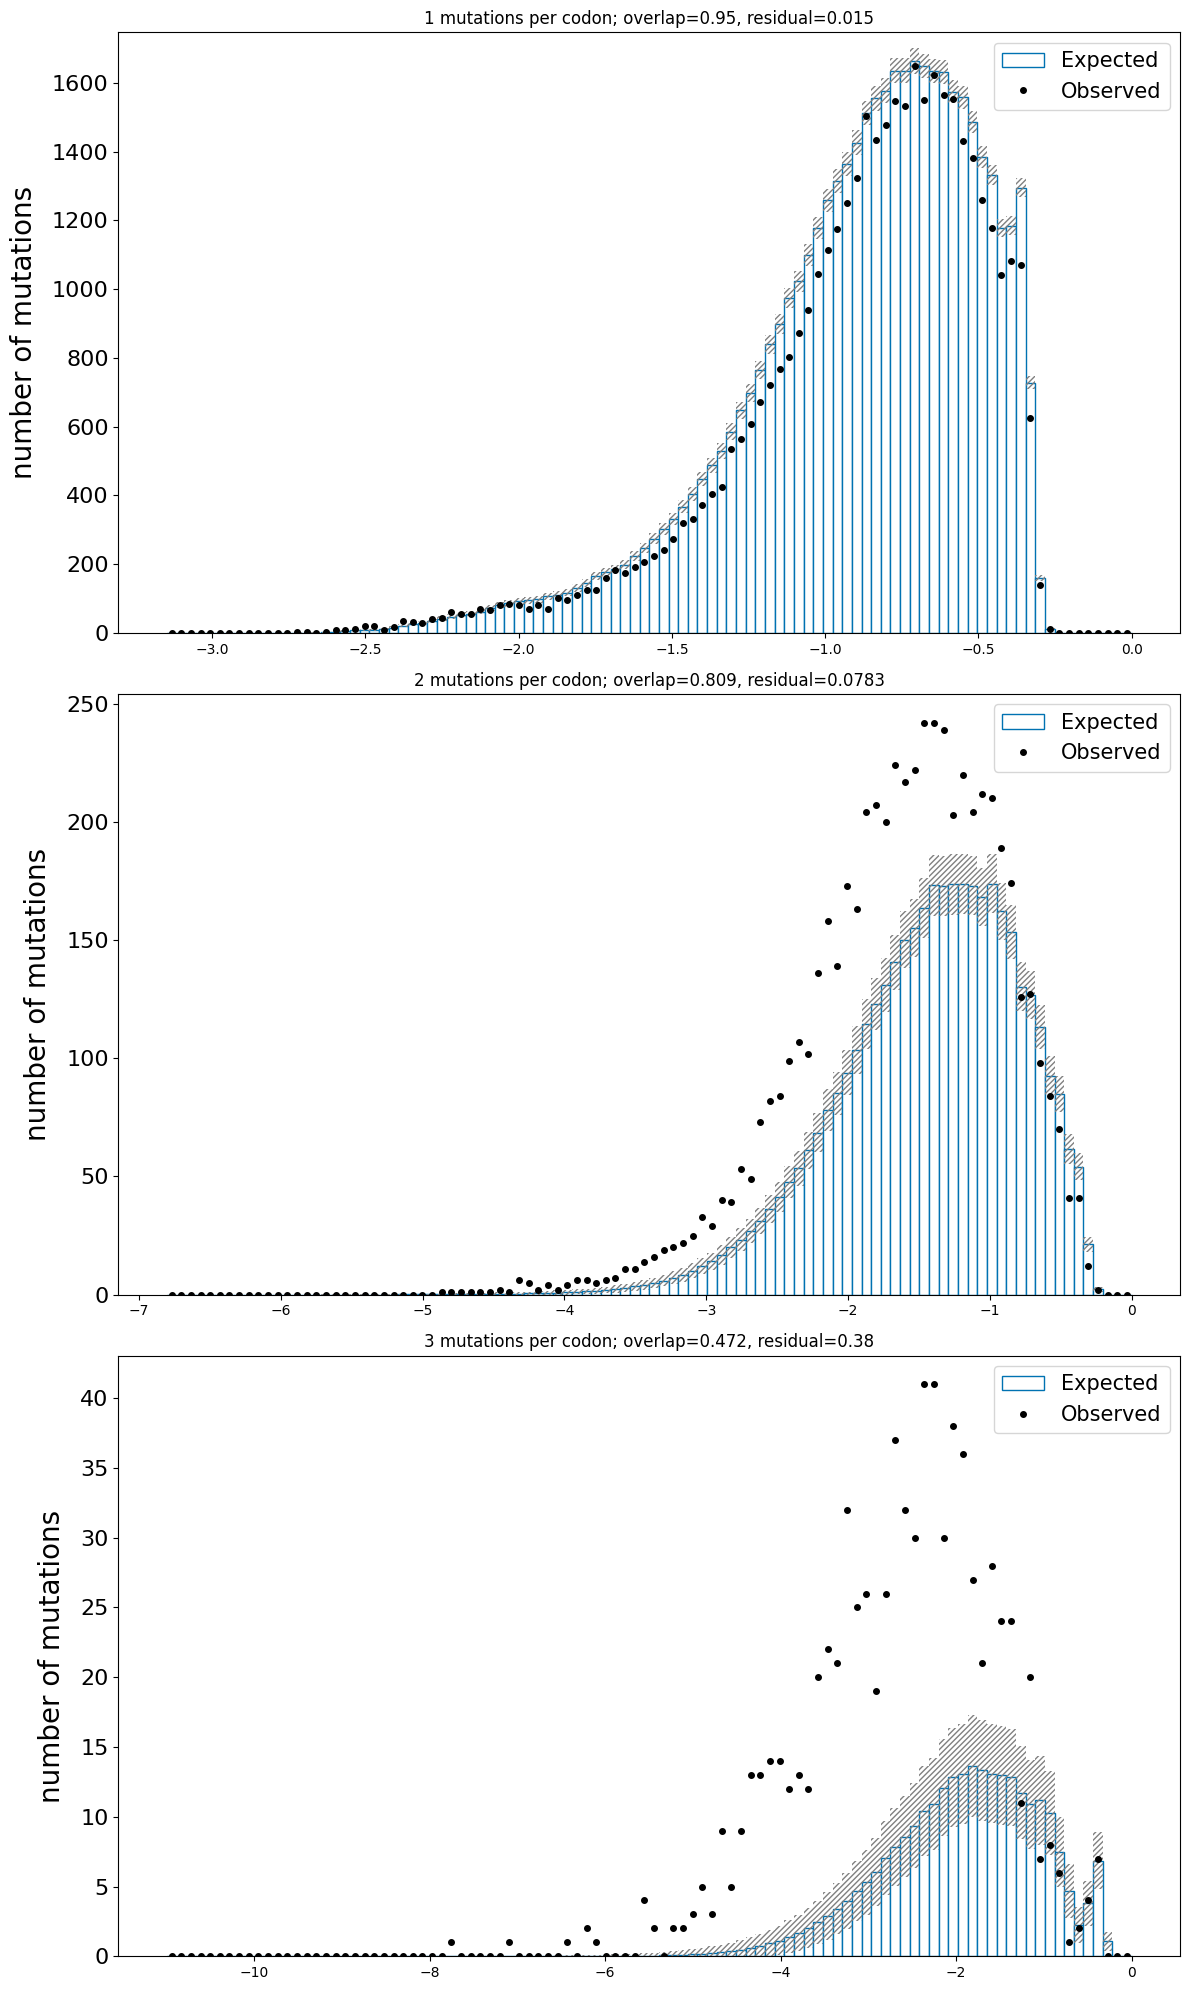

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(12, 20))

for i in range(3):
    hit_class = i + 1
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] == hit_class,
        "prob": hc_site_df[f"{hit_class}_hc_prob"],
    })
    
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[i], None)
    axs[i].set_title(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}")
fig.tight_layout()
fig.savefig(f"_ignore/obs_vs_exp_mutations_per_codon.png")

### Let's look in detail about probabilities in terms of branch length

In [17]:
# select rows of pre_obs_vs_exp_df such that hit_class > 1
multihit_df = hc_site_df[hc_site_df["hit_class"] > 1].copy()
multihit_df["nt_site"] = multihit_df["site"] * 3
multihit_df

,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile,nt_site
2,0,2,2,0.661703,0.299156,0.037716,0.001425,3,6
42,0,42,2,0.874281,0.120668,0.004992,0.000059,3,126
52,0,52,2,0.524600,0.382592,0.086711,0.006097,3,156
56,0,56,2,0.373238,0.444931,0.162905,0.018925,3,168
546,4,56,2,0.615238,0.335906,0.046903,0.001952,3,168
...,...,...,...,...,...,...,...,...,...
610423,4991,54,2,0.559954,0.360984,0.074276,0.004786,3,162
610424,4991,55,2,0.442536,0.427615,0.119723,0.010126,3,165
610425,4991,56,2,0.598254,0.335414,0.062466,0.003866,3,168
610438,4991,69,2,0.666512,0.292802,0.039226,0.001460,3,207


In [18]:
# This block just shows things working for a single parent sequence.

parent, child, rates, subs_probs, branch_length = pcp_df.loc[14, ["parent", "child", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

# hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[[6.2193e-08, 8.1990e-08, 1.4849e-04, 1.4290e-07],
         [2.6677e-11, 3.5168e-11, 6.3693e-08, 6.1297e-11],
         [3.5369e-11, 4.6627e-11, 8.4446e-08, 8.1269e-11],
         [3.4675e-11, 4.5712e-11, 8.2789e-08, 7.9675e-11]],

        [[4.1708e-04, 5.4984e-04, 9.9581e-01, 9.5835e-04],
         [1.7890e-07, 2.3585e-07, 4.2714e-04, 4.1107e-07],
         [2.3719e-07, 3.1269e-07, 5.6632e-04, 5.4501e-07],
         [2.3254e-07, 3.0656e-07, 5.5521e-04, 5.3432e-07]],

        [[1.0360e-07, 1.3657e-07, 2.4734e-04, 2.3804e-07],
         [4.4436e-11, 5.8580e-11, 1.0609e-07, 1.0210e-10],
         [5.8914e-11, 7.7667e-11, 1.4066e-07, 1.3537e-10],
         [5.7758e-11, 7.6143e-11, 1.3790e-07, 1.3272e-10]],

        [[1.3125e-07, 1.7303e-07, 3.1337e-04, 3.0158e-07],
         [5.6299e-11, 7.4219e-11, 1.3442e-07, 1.2936e-10],
         [7.4642e-11, 9.8401e-11, 1.7821e-07, 1.7151e-10],
         [7.3178e-11, 9.6471e-11, 1.7472e-07, 1.6814e-10]]])

In [19]:
valid_length = (len(parent) // 3) * 3

# Chunk into codons and count mutations
mutations = []
for i in range(0, valid_length, 3):
    parent_codon = parent[i:i+3]
    child_codon = child[i:i+3]
    
    if parent_codon != child_codon:
        mutations.append((i, parent_codon, child_codon, codon_to_idxs[child_codon]))

multihit_sites = set([201, 246])
multihit_mutations = [m for m in mutations if m[0] in multihit_sites]
multihit_mutations, mutations

([],
 [(294, 'GCG', 'GAG', (2, 0, 2)),
  (312, 'AAG', 'AAA', (0, 0, 0)),
  (327, 'ACT', 'AAT', (0, 0, 3))])

In [20]:
def mmatch_2(rates):
    """Calculate the moment matching rate for a tensor of two lambda values."""
    inv_rates = 1.0 / rates
    return 1.0 / (inv_rates.sum() - 1.0 / rates.sum())

def mmatch_3(rates):
    """Calculate the moment matching rate for a tensor of three lambda values."""
    inv_rates = 1.0 / rates
    
    # Create a matrix of pairwise sums of rates
    pairwise_sums = rates.unsqueeze(0) + rates.unsqueeze(1)
    
    # Extract the lower triangle part excluding the diagonal to avoid self-pairing
    # and ensure each pair is considered only once
    lower_tri = pairwise_sums.tril(-1)
    
    # Filter out zeros and invert each pairwise sum individually
    nonzero_pairwise_sums = lower_tri[lower_tri != 0]
    inv_nonzero_pairwise_sums = 1.0 / nonzero_pairwise_sums
    
    # Sum the inverted pairwise sums
    sum_inv_pairwise_sums = inv_nonzero_pairwise_sums.sum()

    # Final moment matching calculation for three rates
    return 1.0 / (inv_rates.sum() - sum_inv_pairwise_sums + 1.0 / rates.sum())

mmatch_2(rates[87:89])

tensor(0.8788)

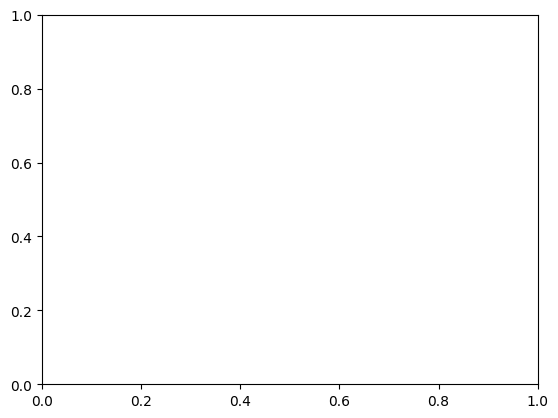

In [21]:
def probability_of_mutation(branch_length, mutation):
    site, _, _, child_idxs = mutation
    scaled_rates = branch_length * rates[:parent_len]

    codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
    site_codon_probs = codon_probs[site//3]
    return site_codon_probs[child_idxs]

# make a plot of probability_of_mutation for each mutation, where branch length ranges from branch_length/2 to 2*branch_length in 100 steps
fig, ax = plt.subplots()
x_values = np.linspace(0.001, 8, 100)

for mutation in multihit_mutations:
    site, _, _, child_idxs = mutation
    probs = [probability_of_mutation(branch_length * factor, mutation) for factor in x_values]
    ax.plot(x_values, probs, label=site)

In [22]:
mmatch_2(0.1*torch.Tensor([1.1764, 1.1049]))

tensor(0.0759)

### Simulated data

In [23]:
sim_df = pd.read_csv("~/data/v0/mimic_shmoof_CNNJoiLrgShmoofSmall.10K.csv.gz", compression="gzip", index_col=0)
sim_df = prepare_pcp_df(sim_df)
sim_df["branch_length"] = optimized_branch_lengths_of_crepe(crepe, sim_df)

Finding optimal branch lengths: 100%|██████████| 9998/9998 [00:46<00:00, 215.56it/s]


In [24]:
sim_hc_site_df = hc_site_df_of_pcp_df(sim_df, hit_class_tensors)
sim_hc_site_df

Consolidating rows: 100%|██████████| 9998/9998 [00:05<00:00, 1947.06it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.989504,0.010467,0.000030,2.508776e-08,3.0
1,0,23,0,0.993705,0.006283,0.000012,7.887737e-09,3.0
2,0,24,0,0.993012,0.006972,0.000016,1.105819e-08,3.0
3,0,25,0,0.987418,0.012529,0.000053,7.303075e-08,3.0
4,0,26,0,0.988747,0.011211,0.000041,4.872031e-08,3.0
...,...,...,...,...,...,...,...,...
935083,9997,113,0,0.954795,0.044541,0.000661,3.112208e-06,NaN
935084,9997,114,0,0.961329,0.038200,0.000469,1.778287e-06,NaN
935085,9997,115,0,0.949878,0.049291,0.000827,4.460576e-06,NaN
935086,9997,116,0,0.969732,0.029959,0.000308,1.055149e-06,NaN


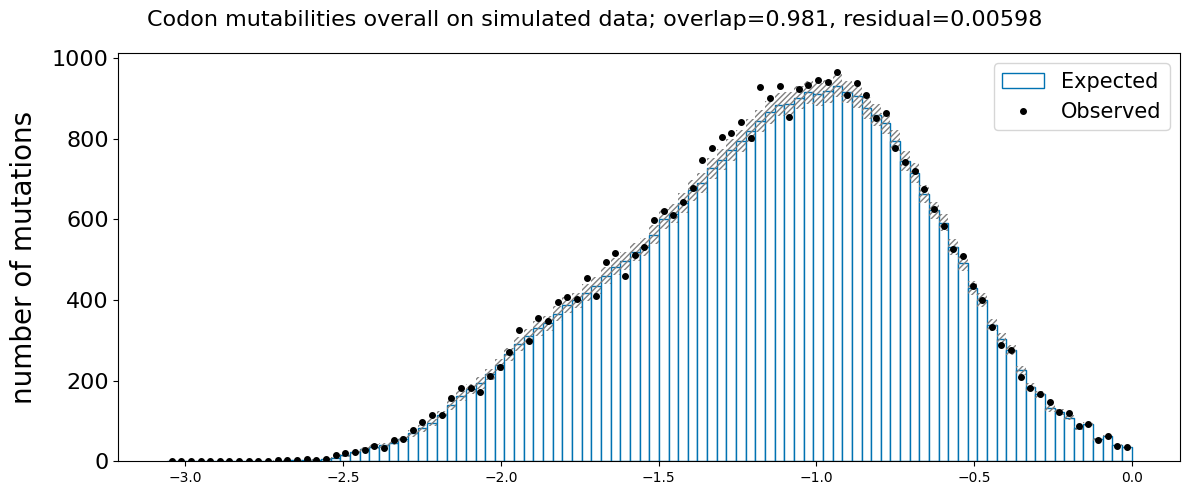

In [25]:
fig, _ = simple_codon_oe_plot(sim_hc_site_df, "Codon mutabilities overall on simulated data")